<p style="font-family: 'Courier New', Courier, monospace; font-size: 40px; font-weight: bold; color: blue;  text-align: center;">
  LoRaWAN Path Loss Measurements in an Indoor Setting: DATA SORTING
</p>

###  Notebook Summary 
This Notebook processes unsorted measurement data by:
- Converting and validating time data.
- Aggregating daily counts and visualizing the data.
- Extracting and analyzing unique gateway IDs.
- Filtering data for a specific gateways.
- Deduplicating data based on time and frame count differences.

###  1. Import Libraries and Load Data

This cell imports the required libraries and loads the dataset from a CSV file. It then prints basic information about the DataFrame.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('../all_data_files/unsorted_combined_measurements_data.csv', low_memory=False)
# Parse and filter by date range on 'time' column
# -----------------------------------------------------------
df['time'] = pd.to_datetime(df['time'], errors='coerce', utc=True)
df = df.dropna(subset=['time'])

start_utc = pd.Timestamp('2024-10-01', tz='UTC')
end_utc   = pd.Timestamp('2025-10-01', tz='UTC')  # exclusive end => keeps through 2025-09-30

df = df.loc[(df['time'] >= start_utc) & (df['time'] < end_utc)].copy()
# sanity check
print("\nTime window (UTC):", start_utc, "to", end_utc, "(exclusive end)")
print("Min time in df:", df['time'].min(), "| Max time in df:", df['time'].max())
# -----------------------------------------------------------

print("\nInitial DataFrame Info:")
df.info()


Time window (UTC): 2024-10-01 00:00:00+00:00 to 2025-10-01 00:00:00+00:00 (exclusive end)
Min time in df: 2024-10-01 00:00:07.374717+00:00 | Max time in df: 2025-09-30 23:59:55.971870+00:00

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3255325 entries, 49294 to 3304620
Data columns (total 94 columns):
 #   Column                                                   Dtype              
---  ------                                                   -----              
 0   correlation_ids_0                                        object             
 1   device_id                                                object             
 2   end_device_ids_application_ids_application_id            object             
 3   end_device_ids_dev_addr                                  object             
 4   end_device_ids_dev_eui                                   object             
 5   end_device_ids_device_id                                 object             
 6   end_device_

### 2. Preprocess Time Data

Convert the 'time' column to datetime (with UTC) and remove invalid entries. Then, extract the date for daily aggregation and plot the unsorted data counts per day.

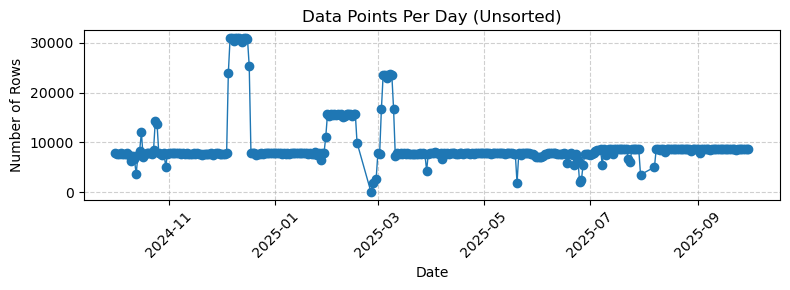

In [28]:
# Create a working copy and convert 'time' to datetime
df = df.copy()
df['time'] = pd.to_datetime(df['time'].astype(str), errors='coerce', utc=True)

# Report and drop rows with invalid datetime values
invalid_times = df[df['time'].isna()]
if not invalid_times.empty:
    print(f"Found {len(invalid_times)} invalid time rows; dropping them.")
df = df.dropna(subset=['time'])

# Extract date for aggregation
df['date'] = df['time'].dt.date

# Plot daily counts (unsorted data)
daily_counts_unsorted = df.groupby('date').size()
plt.figure(figsize=(8, 3))
daily_counts_unsorted.plot(kind='line', marker='o', linestyle='-', linewidth=1)
plt.title('Data Points Per Day (Unsorted)')
plt.xlabel('Date')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 3. Unique Gateway Analysis

Extract unique gateway IDs from metadata columns (e.g., `uplink_message_rx_metadata_0_gateway_ids_gateway_id`), display their count, list them, and compute the number of rows associated with each gateway.


In [29]:
# Gateway summary w/ ID, EUI, and row count per gateway
gateway_id_cols = [f'uplink_message_rx_metadata_{i}_gateway_ids_gateway_id' for i in range(4)]
gateway_eui_cols = [f'uplink_message_rx_metadata_{i}_gateway_ids_eui' for i in range(4)]

gateway_euis = {}
for id_col, eui_col in zip(gateway_id_cols, gateway_eui_cols):
    if id_col not in df.columns:
        continue
    eui_series = df[eui_col] if eui_col in df.columns else pd.Series([pd.NA] * len(df), index=df.index)
    for gw, eui in zip(df[id_col], eui_series):
        if pd.isna(gw):
            continue
        gateway_euis.setdefault(gw, set()).add(eui)

gateway_counts = {}
for gw in gateway_euis:
    mask = pd.Series(False, index=df.index)
    for col in gateway_id_cols:
        if col in df.columns:
            mask |= df[col] == gw
    gateway_counts[gw] = int(mask.sum())

summary = []
for gw in sorted(gateway_euis):
    eui_list = ", ".join(sorted(str(e) for e in gateway_euis[gw] if pd.notna(e))) or "N/A"
    summary.append({
        "gateway_id": gw,
        "gateway_euis": eui_list,
        "row_count": gateway_counts.get(gw, 0),
    })

print(pd.DataFrame(summary))

             gateway_id      gateway_euis  row_count
0      a84041fdfe275e82  A84041FDFE275E82         32
1  eui-a84041ffff22dea4  A84041FFFF22DEA4     361489
2  eui-a84041ffff22def8  A84041FFFF22DEF8    2036881
3      kerlink-istation  7076FF005606004B         15
4            kerlink001  7276FF0039090946    3217141


### Check for duplicates

In [30]:
# Duplicate provenance check (runs on current df)
df_chk = df.copy()
df_chk['time'] = pd.to_datetime(df_chk['time'], errors='coerce', utc=True)
df_chk['received_at_dt'] = pd.to_datetime(df_chk['received_at'], errors='coerce', utc=True)
df_chk['f_cnt_int'] = pd.to_numeric(df_chk['uplink_message_f_cnt'], errors='coerce').astype('Int64')

# 1) TTN event ID repeats: should be unique; repeats imply re-delivery downstream (e.g., MQTT replay)
corr_counts = df_chk['correlation_ids_0'].value_counts()
corr_dups = corr_counts[corr_counts > 1]
print(f"Correlation ID duplicates: {len(corr_dups)} IDs, {corr_dups.sum()} rows total\n")
print("Top 5 corr_id dup counts:\n", corr_dups.head())

# 2) Same device+f_cnt+received_at: should be unique per uplink
trip_counts = (
    df_chk.groupby(['end_device_ids_device_id', 'f_cnt_int', 'received_at_dt'])
    .size()
    .reset_index(name='n')
)
trip_dups = trip_counts[trip_counts['n'] > 1]
print(f"\nDevice+f_cnt+received_at duplicates: {len(trip_dups)} keys, {trip_dups['n'].sum()} rows total\n")
print(trip_dups.head())

# 3)  <2s, same f_cnt rule (sanity check)
df_chk = df_chk.sort_values(['end_device_ids_device_id', 'time'])
g = df_chk.groupby('end_device_ids_device_id', sort=False)
df_chk['dt'] = g['time'].diff().dt.total_seconds()
df_chk['f_diff'] = g['f_cnt_int'].diff()
win_dups = (df_chk['f_diff'] == 0) & (df_chk['dt'] >= 0) & (df_chk['dt'] < 2)
print(f"\n<2s same f_cnt duplicates: {win_dups.sum()} rows")
df_chk.loc[win_dups, ['end_device_ids_device_id', 'time', 'received_at', 'correlation_ids_0']].head()

Correlation ID duplicates: 312653 IDs, 873465 rows total

Top 5 corr_id dup counts:
 correlation_ids_0
gs:uplink:01JNTFXH5B4P7FDNDXW1RTRM4S    6
gs:uplink:01JNEG165DXCJ02A4FNBMZGBAV    6
gs:uplink:01JEB2Z6240XVVAH5M4E46VDX9    5
gs:uplink:01JEB2ZE9VGPANP36B2DV7W3VC    5
gs:uplink:01JEB2ZY373FWMGDPBN3DNVJ1P    5
Name: count, dtype: int64

Device+f_cnt+received_at duplicates: 312644 keys, 873447 rows total

  end_device_ids_device_id  f_cnt_int                      received_at_dt  n
0              pilotdevice          1 2024-10-24 12:25:34.342282157+00:00  2
1              pilotdevice          1 2025-02-03 10:59:09.651668249+00:00  2
2              pilotdevice          1 2025-02-03 11:50:42.225614775+00:00  2
3              pilotdevice          1 2025-02-03 16:27:25.185127032+00:00  2
6              pilotdevice          2 2024-10-24 12:27:35.401064240+00:00  2

<2s same f_cnt duplicates: 560797 rows


,end_device_ids_device_id,time,received_at,correlation_ids_0
156247,pilotdevice,2024-10-15 21:08:01.856511+00:00,2024-10-15T21:08:01.825799860Z,gs:uplink:01JA904QEJP3AA13DQB9TZ9EE2
156255,pilotdevice,2024-10-15 21:09:01.878459+00:00,2024-10-15T21:09:01.849987587Z,gs:uplink:01JA906J25T5Q9MG2MTFEVFYXY
156265,pilotdevice,2024-10-15 21:10:01.811441+00:00,2024-10-15T21:10:01.782800054Z,gs:uplink:01JA908CK8THWM50JCRP3X4YTW
156277,pilotdevice,2024-10-15 21:11:01.860532+00:00,2024-10-15T21:11:01.833077835Z,gs:uplink:01JA90A77RT16890XP4Y6H9X6S
156287,pilotdevice,2024-10-15 21:12:01.909776+00:00,2024-10-15T21:12:01.881914441Z,gs:uplink:01JA90C1W9ZPPEDXDTY6W1N0DE


### 4. Uplink-Level Deduplication (device + frame count, before gateway sorting)

Deduplicate using only end-device + uplink frame count within a 2-second window. This removes repeated receptions before any per-gateway sorting.


Original shape: (3255325, 97)
Removed via correlation_id dedup: 560812
Removed via device+f_cnt+received_at dedup: 0
After dedup: (2694513, 95)
Removed via <2s same f_cnt: 0
Total rows removed: 560812


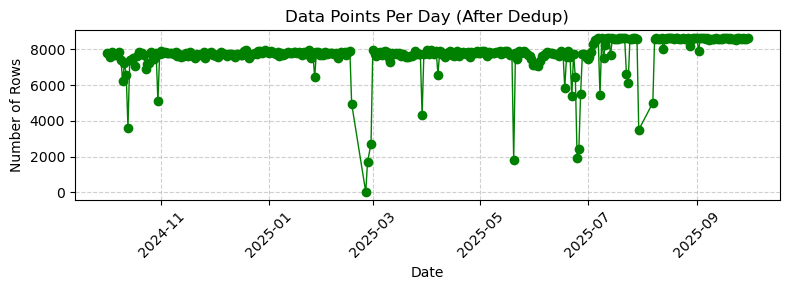

In [31]:
# Dedup: correlation_id -> device+f_cnt+received_at -> <2s same f_cnt
df_uplink = df.copy()
df_uplink['time'] = pd.to_datetime(df_uplink['time'], errors='coerce', utc=True)
df_uplink['received_at_dt'] = pd.to_datetime(df_uplink['received_at'], errors='coerce', utc=True)
df_uplink['f_cnt_int'] = pd.to_numeric(df_uplink['uplink_message_f_cnt'], errors='coerce').astype('Int64')
df_uplink = df_uplink.dropna(subset=['time'])

n0 = len(df_uplink)
print("Original shape:", df_uplink.shape)

# Pass 1: one row per TTN event
df_uplink = df_uplink.drop_duplicates(subset=['correlation_ids_0'], keep='first')
n1 = len(df_uplink)
print(f"Removed via correlation_id dedup: {n0 - n1}")

# Pass 2: guard against replayed IDs
df_uplink = df_uplink.drop_duplicates(
    subset=['end_device_ids_device_id', 'f_cnt_int', 'received_at_dt'], keep='first'
)
n2 = len(df_uplink)
print(f"Removed via device+f_cnt+received_at dedup: {n1 - n2}")

# Pass 3: <2s same f_cnt fallback
df_uplink = df_uplink.sort_values(['end_device_ids_device_id', 'time']).copy()
g = df_uplink.groupby('end_device_ids_device_id', sort=False)
dt = g['time'].diff().dt.total_seconds()
f_diff = g['f_cnt_int'].diff()
dup_mask = (f_diff == 0) & (dt >= 0) & (dt < 2)
removed_pass3 = dup_mask.sum()
df_uplink = df_uplink.loc[~dup_mask].drop(columns=['received_at_dt', 'f_cnt_int'], errors='ignore')

df_uplink = df_uplink.reset_index(drop=True)
n3 = len(df_uplink)
print("After dedup:", df_uplink.shape)
print(f"Removed via <2s same f_cnt: {removed_pass3}")
print(f"Total rows removed: {n0 - n3}")

# Daily counts
df_uplink['date'] = df_uplink['time'].dt.date
daily_counts_uplink = df_uplink.groupby('date').size()
plt.figure(figsize=(8, 3))
daily_counts_uplink.plot(kind='line', marker='o', linewidth=1, color='green')
plt.title('Data Points Per Day (After Dedup)')
plt.xlabel('Date')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Dedup summary:**
 duplicates came from downstream replay (e.g., MQTT redelivery/overlap), not air retries; TTN emitted one event but it was ingested multiple times.

### 5. Filter & Sort Per Target Gateway (after uplink dedup)

Use the deduplicated uplink data, select target gateways, and sort per gateway/device/time for reporting.


Rows per gateway (overlaps counted) after dedup:
 kerlink001              2663638
eui-a84041ffff22def8    1647896
eui-a84041ffff22dea4     283710
dtype: int64
Rows with N matching gateways (post-dedup): {1: 1048381, 2: 1391533, 3: 254599}
Shape after dedup -> per-gateway sorting: (4595244, 96)


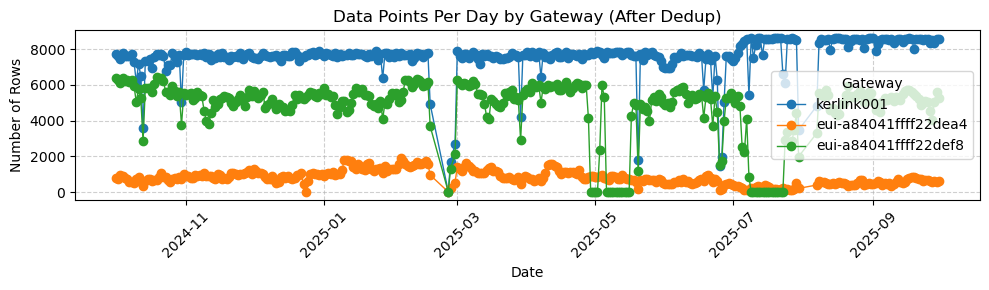

In [32]:
gateway_cols = [f'uplink_message_rx_metadata_{i}_gateway_ids_gateway_id' for i in range(3)]

df_uplink_dedup = df_uplink  # already deduped above
target_gateways = ["kerlink001", "eui-a84041ffff22dea4", "eui-a84041ffff22def8"]

hit_matrix = pd.DataFrame({gw: df_uplink_dedup[gateway_cols].eq(gw).any(axis=1) for gw in target_gateways})

per_gw_counts = hit_matrix.sum().sort_values(ascending=False)
print("Rows per gateway (overlaps counted) after dedup:\n", per_gw_counts)

overlap_sizes = hit_matrix.sum(axis=1).value_counts().sort_index()
print("Rows with N matching gateways (post-dedup):", overlap_sizes.to_dict())

per_gw_frames, daily_by_gw = [], {}
for gw in target_gateways:
    sub = df_uplink_dedup.loc[hit_matrix[gw]].copy()
    sub['gateway_id'] = gw
    sub['time'] = pd.to_datetime(sub['time'], errors='coerce', utc=True)
    sub = sub.dropna(subset=['time']).sort_values(['gateway_id', 'end_device_ids_device_id', 'time'])
    sub['date'] = sub['time'].dt.date
    per_gw_frames.append(sub)
    daily_by_gw[gw] = sub.groupby('date').size()

df_dedup_by_gw = pd.concat(per_gw_frames, ignore_index=True)
print("Shape after dedup -> per-gateway sorting:", df_dedup_by_gw.shape)

daily_df = pd.DataFrame(daily_by_gw).fillna(0)
plt.figure(figsize=(10, 3))
for gw in daily_df.columns:
    plt.plot(daily_df.index, daily_df[gw], marker="o", linewidth=1, label=gw)
plt.title("Data Points Per Day by Gateway (After Dedup)")
plt.xlabel("Date")
plt.ylabel("Number of Rows")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Gateway")
plt.tight_layout()
plt.show()

### 6. Post-Dedup Sanity Check

Confirm no residual duplicates per gateway (same device/frame count within 2s) remain after uplink-level deduplication and gateway sorting.


In [33]:
# Residual dup check after per-gateway expansion
chk = df_dedup_by_gw.copy()
chk['time'] = pd.to_datetime(chk['time'], errors='coerce', utc=True)
chk['f_cnt_int'] = pd.to_numeric(chk['uplink_message_f_cnt'], errors='coerce').astype('Int64')
chk = chk.dropna(subset=['time'])

chk = chk.sort_values(['gateway_id', 'end_device_ids_device_id', 'time'])
g2 = chk.groupby(['gateway_id', 'end_device_ids_device_id'], sort=False)
chk['dt_check'] = g2['time'].diff().dt.total_seconds()
chk['f_cnt_diff_check'] = g2['f_cnt_int'].diff()
resid_dups = ((chk['f_cnt_diff_check'] == 0) & (chk['dt_check'] >= 0) & (chk['dt_check'] < 2)).sum()
print(f"Residual duplicates (<2s, same f_cnt): {resid_dups}")

df_dedup_final = chk.drop(columns=['dt_check', 'f_cnt_diff_check', 'f_cnt_int'], errors='ignore').reset_index(drop=True)

Residual duplicates (<2s, same f_cnt): 0


### 7. Save Cleaned Data and Preview

Save the cleaned, deduplicated dataset to a CSV file and display the last 10 rows as a preview.

In [34]:
# Save the cleaned data to CSV
df_dedup_final.to_csv('../LoRaWAN Localization - Advanced Files/all3_gateways_combined_measurements_data.csv', index=False)
print("Data cleaning and deduplication completed. CSV file saved.")

# Display the tail of the deduplicated DataFrame
df_dedup_final.tail(10)

Data cleaning and deduplication completed. CSV file saved.


,correlation_ids_0,device_id,end_device_ids_application_ids_application_id,end_device_ids_dev_addr,end_device_ids_dev_eui,end_device_ids_device_id,end_device_ids_join_eui,received_at,time,uplink_message_confirmed,...,uplink_message_settings_frequency,uplink_message_settings_time,uplink_message_settings_timestamp,uplink_message_version_ids_band_id,uplink_message_version_ids_brand_id,uplink_message_version_ids_firmware_version,uplink_message_version_ids_hardware_version,uplink_message_version_ids_model_id,date,gateway_id
4595234,gs:uplink:01JJRVY5D7HRC56E69HJNR1BAJ,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:07:57.944410062Z,2025-01-29 11:07:57.971066+00:00,True,...,868500000,2025-01-29T11:07:57.675045Z,3.211643e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595235,gs:uplink:01JJRW0G2RXG9M7MTBY4TNVRZ5,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:09:14.405190448Z,2025-01-29 11:09:14.433548+00:00,True,...,867900000,2025-01-29T11:09:14.142329Z,3.288110e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595236,gs:uplink:01JJRW3NEC152Y4RH68WMK5JQN,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:10:58.203436452Z,2025-01-29 11:10:58.231703+00:00,True,...,868100000,2025-01-29T11:10:57.957262Z,3.391925e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595237,gs:uplink:01JJRW6042AY1EC1JCAPWG36KY,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:12:14.686310289Z,2025-01-29 11:12:14.714619+00:00,True,...,867500000,2025-01-29T11:12:14.423554Z,3.468392e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595238,gs:uplink:01JJRW78WMJDKKJ3ARVFR473R9,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:12:56.423484950Z,2025-01-29 11:12:56.450676+00:00,True,...,868500000,2025-01-29T11:12:56.173194Z,3.510141e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595239,gs:uplink:01JJRW93HHYTCP1G6DEB524JPX,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:13:56.483298039Z,2025-01-29 11:13:56.511742+00:00,True,...,867900000,2025-01-29T11:13:56.225962Z,3.570194e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595240,gs:uplink:01JJRWAXN566DRPYZ0EVXK1944,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:14:55.986247587Z,2025-01-29 11:14:56.014379+00:00,True,...,868300000,2025-01-29T11:14:55.747108Z,3.629715e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595241,gs:uplink:01JJRWCRA1CNF45JY7F8RQSGWK,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:15:56.045457219Z,2025-01-29 11:15:56.074514+00:00,True,...,867900000,2025-01-29T11:15:55.802812Z,3.689771e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595242,gs:uplink:01JJRWEJYSJVH43SGSPYDY3K60,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:16:56.105283552Z,2025-01-29 11:16:56.132382+00:00,True,...,867500000,2025-01-29T11:16:55.859469Z,3.749827e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595243,gs:uplink:01JJRWGDKHQN7BP9CMK1FSKVE2,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:17:56.162296967Z,2025-01-29 11:17:56.189602+00:00,True,...,867100000,2025-01-29T11:17:55.916136Z,3.809884e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
